In [36]:
%load_ext autoreload
%autoreload 2

import os

subj = "Subj1"
N_STAGES = 9

exp = "exp_full_flow"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import typing

import mne
import umap
import tqdm
import numpy
import pandas
import joblib
import itertools
import IPython.display
import sklearn.metrics
import matplotlib.colors
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
import matplotlib.pyplot as plt
import sklearn.cross_decomposition

import SDA.topology
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

from full_flow.AutoEncoder import AutoEncoder

In [30]:
QSDA_THRESHOLD = 0.4
UNIQUE_VALUES_THRESHOLD = 200
TRY_NUM_FEATURES = list(range(10, 201, 10))

print(len(TRY_NUM_FEATURES))
print(TRY_NUM_FEATURES)

20
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [31]:
def explained_variance(features, reduced):
    pls = sklearn.cross_decomposition.PLSRegression(n_components = reduced.shape[1])
    pls = pls.fit(reduced, features)
    y_pred = pls.predict(reduced)
    return sklearn.metrics.r2_score(features, y_pred, multioutput = "variance_weighted")

### Data

Opening raw data file Subj2/src/data_rr_filt-raw.fif...
    Range : 4000 ... 1176000 =      8.000 ...  2352.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj2\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
2019 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


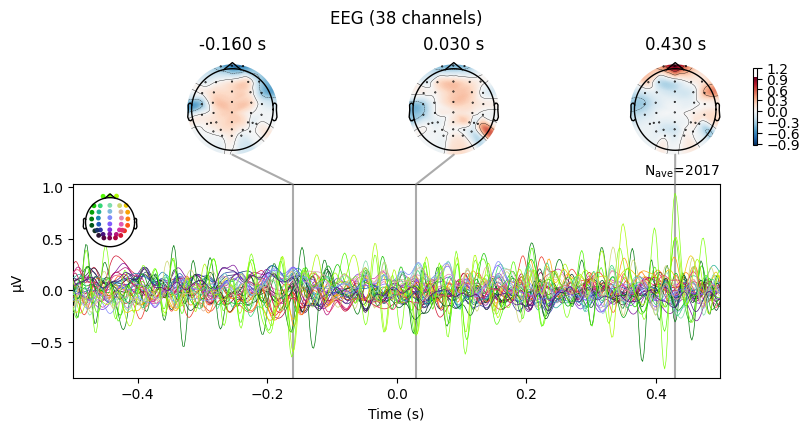

In [32]:
edges_true = numpy.loadtxt(f"{subj}/{exp}/target_edges.txt").astype(numpy.int32)

raw_data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif").drop_channels(ch_names = [ "A1", "A2" ])
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif").drop_channels(ch_names = [ "A1", "A2" ])
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]

epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)

### Features

In [33]:
per_channel_folder = f"{subj}/{exp}/features/per_channel"
os.makedirs(per_channel_folder, exist_ok = True)
per_channel_extractor = SDA.topology.PerChannelFeatureExtractor(n_jobs = -1, folder = per_channel_folder)
per_channel_features = per_channel_extractor.extract(data)

dissimilarity_folder = f"{subj}/{exp}/features/dissimilarity"
os.makedirs(dissimilarity_folder, exist_ok = True)
dissimilarity_extractor = SDA.topology.DissimilarityFeatureExtractor(n_jobs = -1, folder = dissimilarity_folder)
dissimilarity_features = dissimilarity_extractor.extract(data)

overall_folder = f"{subj}/{exp}/features/overall"
os.makedirs(overall_folder, exist_ok = True)
overall_extractor = SDA.topology.OverallFeatureExtractor(n_jobs = -1, folder = overall_folder)
overall_features = overall_extractor.extract(data)

all_features = pandas.concat([
    per_channel_features,
    dissimilarity_features,
    overall_features
], axis = 1)

all_features.to_feather(f"{subj}/{exp}/features/all_features.feather")
display(all_features)

Got features from Subj2/exp_full_flow/features/per_channel/features.feather
Got features from Subj2/exp_full_flow/features/dissimilarity/features.feather
Got features from Subj2/exp_full_flow/features/overall/features.feather


,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,14.0,0.0,1.825742,0.0,0.0,0.0,0.0,38.721818,3.216625,40.0,...,0.000053,0.000003,0.000320,0.000051,0.000051,0.000056,-1.495208,0.691433,0.000320,0.000131
1,15.0,0.0,2.518618,0.0,0.0,0.0,0.0,22.099426,0.766268,62.0,...,0.000059,0.000004,0.001942,0.000057,0.000058,0.000058,10.903669,3.421107,0.001942,0.000339
2,18.0,0.0,3.068247,0.0,0.0,0.0,0.0,21.558981,1.680651,76.0,...,0.000060,0.000004,0.001315,0.000057,0.000059,0.000061,1.295857,1.334261,0.001315,0.000281
3,11.0,0.0,1.922751,0.0,0.0,0.0,0.0,21.233405,1.875728,48.0,...,0.000070,0.000004,0.000976,0.000067,0.000068,0.000073,-0.902219,0.596983,0.000976,0.000261
4,13.0,0.0,2.251823,0.0,0.0,0.0,0.0,21.975104,0.838630,54.0,...,0.000070,0.000007,0.000489,0.000063,0.000065,0.000078,-1.884211,0.283955,0.000489,0.000186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,6.0,0.0,1.163415,0.0,0.0,0.0,0.0,11.235799,0.692762,38.0,...,0.000087,0.000004,0.003823,0.000083,0.000088,0.000090,-1.206499,-0.333461,0.003823,0.000577
2013,12.0,0.0,1.922751,0.0,0.0,0.0,0.0,19.628191,1.986567,54.0,...,0.000101,0.000006,0.002725,0.000096,0.000103,0.000104,-0.749364,-0.117075,0.002725,0.000525
2014,18.0,0.0,2.490386,0.0,0.0,0.0,0.0,29.628330,2.860512,66.0,...,0.000086,0.000003,0.003027,0.000084,0.000086,0.000087,-0.622809,0.416047,0.003027,0.000512
2015,5.0,0.0,1.524215,0.0,0.0,0.0,0.0,5.560038,0.034230,62.0,...,0.000103,0.000014,0.000620,0.000090,0.000104,0.000116,-1.844843,-0.040469,0.000620,0.000256


In [34]:
features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
features = pandas.DataFrame(features, columns = all_features.columns)

features.to_feather(f"{subj}/{exp}/features/features.feather")
display(features)

numpy.save(f"{subj}/{exp}/features/features.npy", features.to_numpy())

,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,0.899263,0.0,-0.174019,0.0,0.0,0.0,0.0,2.444957,1.551471,-1.303890,...,-2.196665,-0.677391,-1.161069,-2.226921,-2.242439,-1.993789,-0.763455,0.807510,-1.161069,-1.683220
1,1.156871,0.0,1.201929,0.0,0.0,0.0,0.0,0.363756,0.013060,0.525927,...,-1.871891,-0.528299,-0.004338,-1.822444,-1.866922,-1.894704,4.955345,3.550431,-0.004338,-0.372904
2,1.929693,0.0,2.293411,0.0,0.0,0.0,0.0,0.296090,0.587138,1.690356,...,-1.818778,-0.646479,-0.451729,-1.832526,-1.812704,-1.733627,0.523883,1.453458,-0.451729,-0.738976
3,0.126441,0.0,0.018626,0.0,0.0,0.0,0.0,0.255327,0.709614,-0.638502,...,-1.236203,-0.628103,-0.693403,-1.206922,-1.274433,-1.132382,-0.489948,0.712602,-0.693403,-0.862766
4,0.641656,0.0,0.672115,0.0,0.0,0.0,0.0,0.348191,0.058491,-0.139461,...,-1.224264,0.081471,-1.040261,-1.435449,-1.465497,-0.896999,-0.942877,0.398056,-1.040261,-1.336682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,-1.161596,0.0,-1.489300,0.0,0.0,0.0,0.0,-0.996420,-0.033089,-1.470237,...,-0.228154,-0.606584,1.336991,-0.228267,-0.159598,-0.273213,-0.630292,-0.222357,1.336991,1.125853
2013,0.384048,0.0,0.018626,0.0,0.0,0.0,0.0,0.054346,0.779202,-0.139461,...,0.594249,-0.161130,0.553799,0.615936,0.654725,0.446165,-0.419446,-0.004921,0.553799,0.800784
2014,1.929693,0.0,1.145864,0.0,0.0,0.0,0.0,1.306410,1.327892,0.858621,...,-0.251224,-0.774080,0.769550,-0.128120,-0.256724,-0.395974,-0.361074,0.530789,0.769550,0.717214
2015,-1.419204,0.0,-0.772805,0.0,0.0,0.0,0.0,-1.707051,-0.446536,0.525927,...,0.740415,1.554958,-0.946717,0.198356,0.754508,1.088781,-0.924719,0.072057,-0.946717,-0.897191


### Feature selection

In [35]:
os.makedirs(f"{subj}/{exp}/qsda", exist_ok = True)
qsda = SDA.QSDA(
    n_jobs = 1,
    qsda_n_jobs = 14,
    scores_folder = f"{subj}/{exp}/qsda",

    threshold = QSDA_THRESHOLD,
    min_unique_values = UNIQUE_VALUES_THRESHOLD
)
best_features, scores = qsda.select(features)

best_features.to_feather(f"{subj}/{exp}/qsda/best_features.feather")
numpy.save(f"{subj}/{exp}/qsda/best_features.npy", features.to_numpy())
display(best_features)
display(scores)

scores:   6%|▌         | 1058/19143 [1:05:41<18:42:52,  3.73s/it]


KeyboardInterrupt: 

### Dimensionality reduction

In [9]:
print(TRY_NUM_FEATURES)
for n_components in TRY_NUM_FEATURES:
    file = f"{subj}/{exp}/features_reduced/rtd_ae/{n_components}/features.npy"
    if not os.path.exists(file):
        raise NotImplementedError(f'Need to run RTD_AE for {n_components} components manually')

class RTDAutoEncoder:
    def __init__(self, n_components: int):
        self.n_components = n_components

    def fit_transform(self, features: numpy.ndarray):
        return numpy.load(f"{subj}/{exp}/features_reduced/rtd_ae/{self.n_components}/features.npy")

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [10]:
def make_reduced(
    methods: typing.List[typing.Tuple[str, typing.Callable[[numpy.ndarray], numpy.ndarray]]],
    full_features: pandas.DataFrame
):
    def reduce(name: str, method, n_components: int, full_features: numpy.ndarray):
        folder = f"{subj}/{exp}/features_reduced/{name}/{n_components}"
        os.makedirs(folder, exist_ok = True)
        
        features_file = f"{folder}/features.npy"
        if os.path.exists(features_file):
            reduced_features = numpy.load(features_file)
        else:
            reduced_features = method.fit_transform(full_features)
            numpy.save(features_file, reduced_features)
        
        explained_variance_file = f"{folder}/explained_variance.txt"
        if not os.path.exists(explained_variance_file):
            ev = explained_variance(full_features, reduced_features)
            numpy.savetxt(explained_variance_file, [ ev ])
        
        results_file = f"{folder}/results.csv"
        if not os.path.exists(results_file):
            sda = SDA.SDA(n_jobs = 1, scale = False, verbose = False, st1_calc_quality = False)
            results, _ = sda.apply(reduced_features)
            results.to_csv(results_file, index = False)

    generator = joblib.Parallel(return_as = "generator", n_jobs = -1)(
        joblib.delayed(reduce)(name, method(n_components = n_components, **params), n_components, full_features.to_numpy())
        for n_components, (name, method, params) in itertools.product(TRY_NUM_FEATURES, methods)
    )
    list(tqdm.tqdm(generator, total = len(methods) * len(TRY_NUM_FEATURES)))

methods = [
    ('pca', sklearn.decomposition.PCA, { 'svd_solver': "full", 'random_state': 42 }),
    ('umap', umap.UMAP, { 'random_state': 42 }),
    ('ae', AutoEncoder, { 'n_features': best_features.shape[1] }),
    ('rtd_ae', RTDAutoEncoder, { })
]
make_reduced(methods, best_features)

 24%|██▍       | 19/80 [13:41<34:28, 33.90s/it]  d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 80/80 [50:04<00:00, 37.56s/it]  


rtd_ae: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


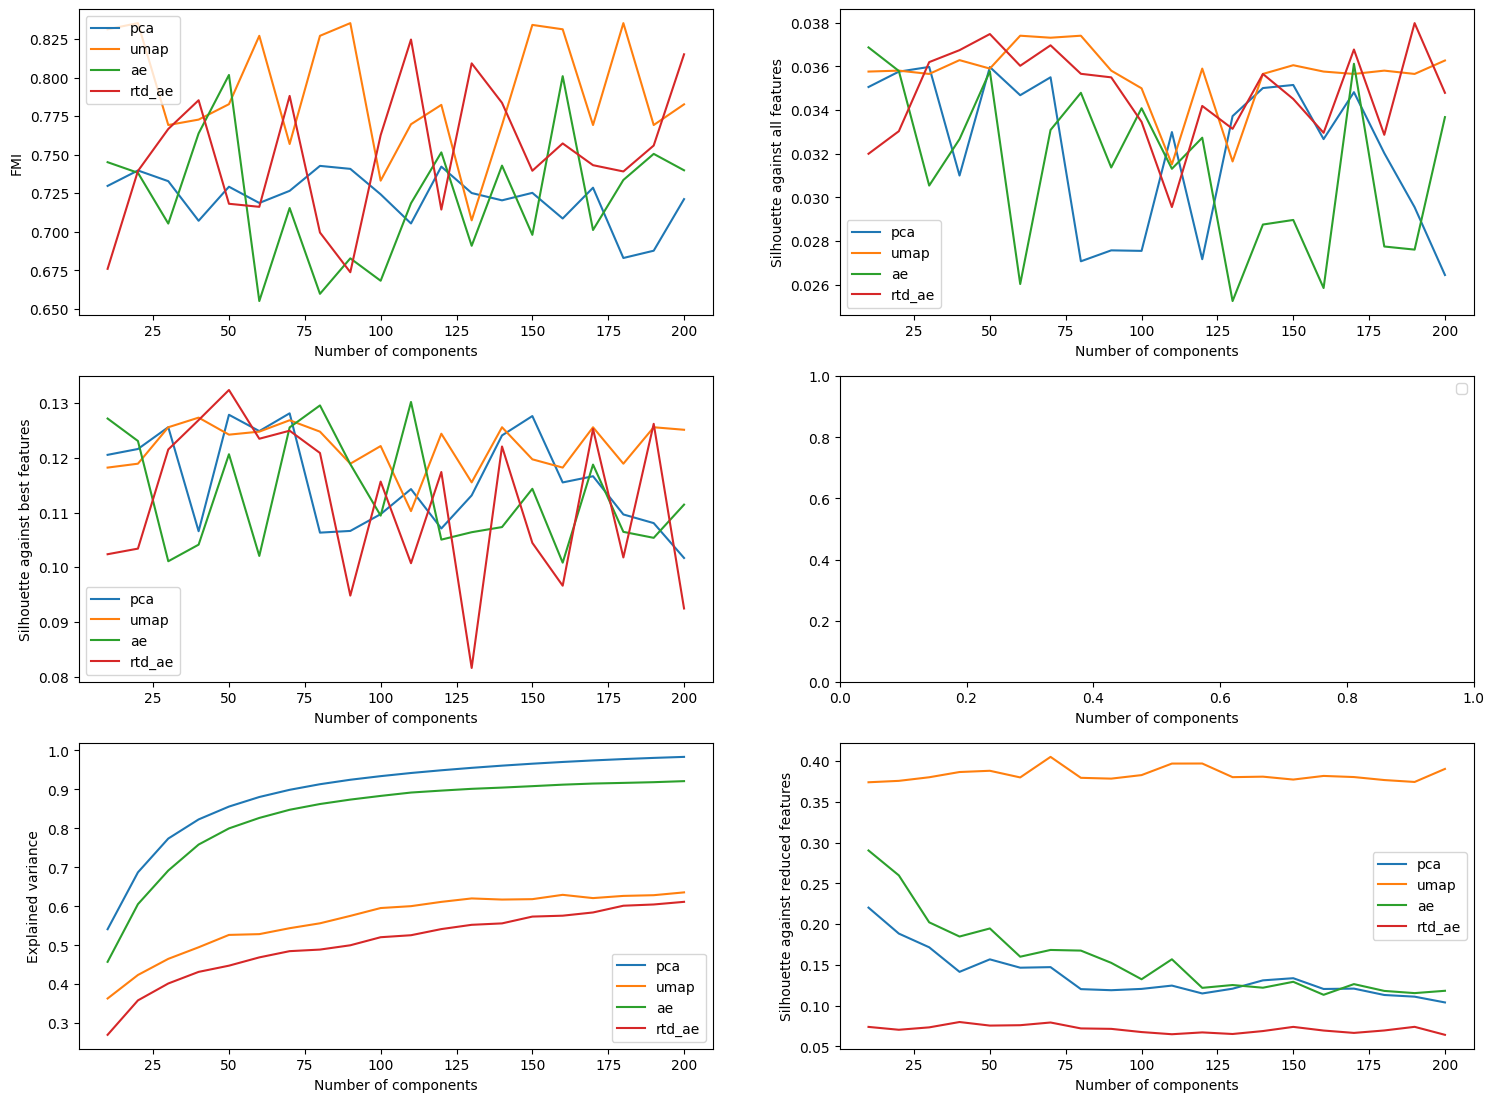

In [11]:
fig, axes = plt.subplots(3, 2, figsize = (18, 13.5))
ax_fmi, ax_silh_all, ax_silh_best, _, ax_explained_variance, ax_silh_reduced = axes.flat

for (name, _, __) in methods:
    fmis = [ ]
    silh_all = [ ]
    silh_best = [ ]
    silh_reduced = [ ]
    explained_variance = [ ]

    for n_components in tqdm.tqdm(TRY_NUM_FEATURES, desc = name):
        folder = f"{subj}/{exp}/features_reduced/{name}/{n_components}"

        reduced_features = numpy.load(f"{folder}/features.npy")
        assert reduced_features.shape == (data.shape[0], n_components)

        explained_variance.append(float(numpy.loadtxt(f"{folder}/explained_variance.txt")))

        results = pandas.read_csv(f"{folder}/results.csv")
        try:
            result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
            edges = numpy.fromstring(result['St_edges'].strip('[]'), sep = ' ', dtype = numpy.uint)
        except:
            edges = None
    
        if edges is not None:
            fmis.append(SDA.clustquality.cluster_metrics_ground(edges_true, edges, [ "FMI" ])["FMI"])
            silh_all.append(SDA.clustquality.calc_stage_metr_noground(features, edges, [ "Silh" ]).mean()["Silh"])
            silh_best.append(SDA.clustquality.calc_stage_metr_noground(best_features, edges, [ "Silh" ]).mean()["Silh"])
            silh_reduced.append(SDA.clustquality.calc_stage_metr_noground(reduced_features, edges, [ "Silh" ]).mean()["Silh"])
        else:
            fmis.append(fmis[-1])
            silh_all.append(silh_all[-1])
            silh_best.append(silh_best[-1])
            silh_reduced.append(silh_reduced[-1])

    ax_fmi.plot(TRY_NUM_FEATURES, fmis, label = name)
    ax_silh_all.plot(TRY_NUM_FEATURES, silh_all, label = name)
    ax_silh_best.plot(TRY_NUM_FEATURES, silh_best, label = name)
    ax_silh_reduced.plot(TRY_NUM_FEATURES, silh_reduced, label = name)
    ax_explained_variance.plot(TRY_NUM_FEATURES, explained_variance, label = name)

ax_fmi.yaxis.set_label_text("FMI")
ax_explained_variance.yaxis.set_label_text("Explained variance")
ax_silh_all.yaxis.set_label_text("Silhouette against all features")
ax_silh_best.yaxis.set_label_text("Silhouette against best features")
ax_silh_reduced.yaxis.set_label_text("Silhouette against reduced features")

for ax in axes.flat:
    ax.legend()
    ax.xaxis.set_label_text('Number of components')

fig.savefig(f"{subj}/{exp}/features_reduced/comparison.svg")

### Results

#### Estimator

In [12]:
def analyze(all_features: pandas.DataFrame, n_components: int, folder: str):
    folder = f"{subj}/{exp}/results/{folder}"
    os.makedirs(folder, exist_ok = True)

    # Scale features
    all_features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
    print(all_features.shape)
    numpy.save(f"{folder}/all_features.npy", all_features)
    numpy.savetxt(f"{folder}/all_features_shape.txt", all_features.shape)

    # PCA
    pca = sklearn.decomposition.PCA(n_components = n_components, svd_solver = "full", random_state = 42)
    pca_features = pca.fit_transform(all_features)
    print(pca_features.shape)
    numpy.save(f"{folder}/pca_features.npy", pca_features)
    numpy.savetxt(f"{folder}/pca_features_shape.txt", pca_features.shape)
    
    print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
    print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
    numpy.savetxt(f"{folder}/explained_variance.txt", [ pca.explained_variance_ratio_.sum() ])
    numpy.savetxt(f"{folder}/explained_variance_ratios.txt", pca.explained_variance_ratio_)

    # SDA
    sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
    results, df_st_edges = sda.apply(pca_features)
    
    metrics = [ ]
    for row in tqdm.tqdm(results['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    results = pandas.concat([ results, pandas.DataFrame(metrics) ], axis = 1)
    
    results.to_csv(f"{folder}/results.csv")
    df_st_edges.to_csv(f"{folder}/df_st_edges.csv")

    # Analyze
    best_results = SDA.analytics.best_results(results, key = 'Avg-Silh')
    best_results.to_csv(f"{folder}/best_results.csv")
    
    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_eeg_stages(raw_data, best_edges, epochs).savefig(f"{folder}/eeg_stages.svg")
    SDA.analytics.plot_stats(pca_features, epochs, best_result, df_st_edges).savefig(f"{folder}/stats.svg")

#### Традиционные признаки

(1046, 765)
(1046, 15)
Explained variance 0.71
[0.211, 0.156, 0.069, 0.063, 0.046, 0.032, 0.026, 0.02, 0.018, 0.015, 0.013, 0.012, 0.01, 0.009, 0.009]
Applying to 1046 samples with 15 features each


100%|██████████| 1344/1344 [00:04<00:00, 329.61it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,45,15,Median,40,"[0, 104, 282, 492, 560, 682, 784, 857, 976, 1046]",9,210,68,116.222222,...,20.577614,0.051424,84.802755,3.014466,0.19782,66.881786,1.740748,1.0,1.0,1.0


array([   0,  104,  282,  492,  560,  682,  784,  857,  976, 1046])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 101.1)","(101.9, 263.5)","(264.3, 455.5)","(456.3, 511.5)","(513.1, 620.3)","(621.1, 707.5)","(708.3, 771.5)","(772.3, 877.1)","(877.9, 938.7)"
"Time length, sec",91.2,161.6,191.2,55.2,107.2,86.4,63.2,104.8,60.8
Number of epochs,104,178,210,68,122,102,73,119,70


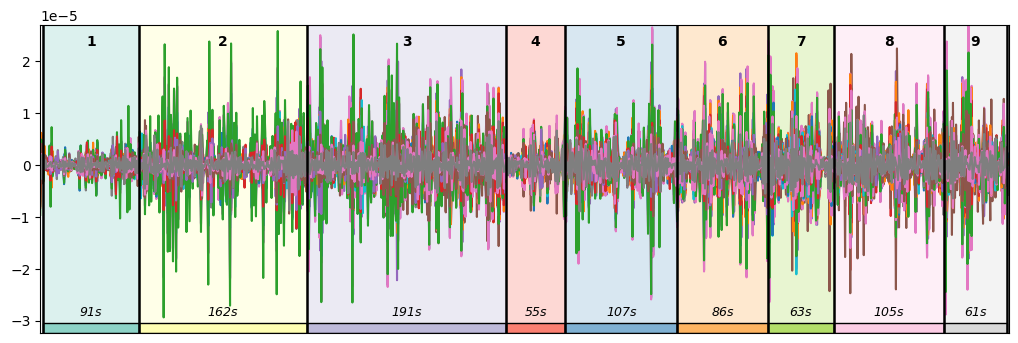

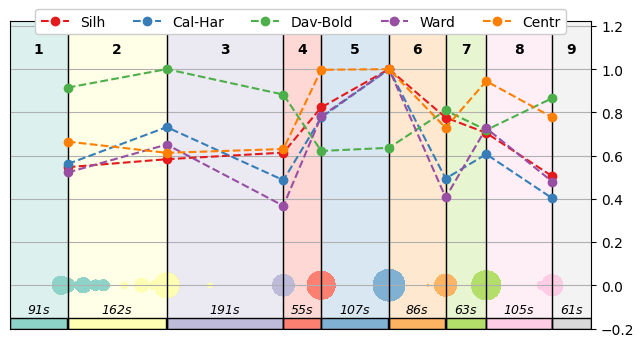

In [13]:
def read_traditional():
    df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
    df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
    df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
    df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

    result =  pandas.concat([
        df_ft_psd_loc_db,
        df_ft_psd_ind_loc_log,
        df_ft_coh_ind_loc,
        df_ft_plv_ind_loc
    ], axis = 1)

    if subj == "Subj2":
        result = result[:-2]
    return result

analyze(read_traditional(), 15, "traditional")

#### Топологические признаки + PCA

(1046, 19143)
(1046, 15)
Explained variance 0.27
[0.093, 0.031, 0.026, 0.016, 0.013, 0.013, 0.011, 0.01, 0.009, 0.009, 0.008, 0.008, 0.008, 0.007, 0.007]
Applying to 1046 samples with 15 features each


100%|██████████| 1344/1344 [00:04<00:00, 330.50it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,35,20,Median,40,"[0, 91, 210, 486, 556, 682, 795, 856, 976, 1046]",9,276,61,116.222222,...,48.827074,0.000277,47.326284,4.741024,0.126017,38.373871,2.407877,0.880604,0.770443,0.802188


array([   0,   91,  210,  486,  556,  682,  795,  856,  976, 1046])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 88.3)","(89.1, 198.7)","(199.5, 449.9)","(450.7, 508.3)","(509.1, 620.3)","(621.1, 717.1)","(719.5, 770.7)","(771.5, 877.1)","(877.9, 938.7)"
"Time length, sec",78.4,109.6,250.4,57.6,111.2,96.0,51.2,105.6,60.8
Number of epochs,91,119,276,70,126,113,61,120,70


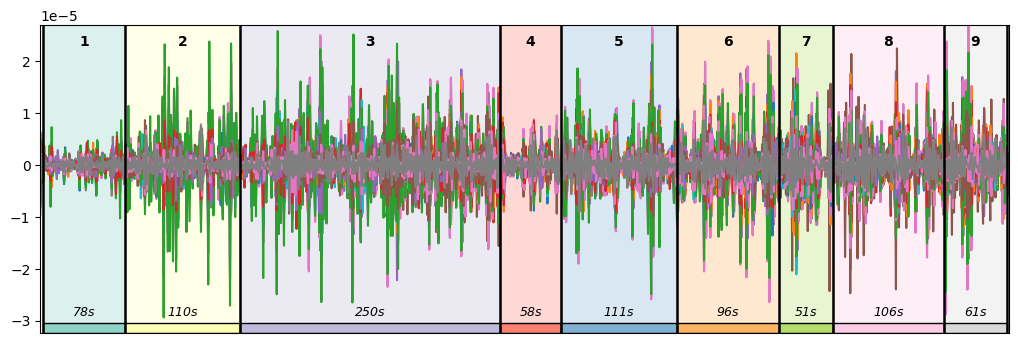

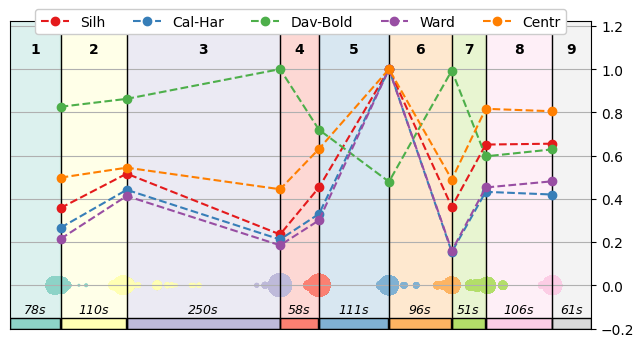

In [14]:
analyze(features, 15, "topological")

#### Топологические признаки + QSDA + PCA

(1046, 1650)
(1046, 15)
Explained variance 0.62
[0.207, 0.089, 0.065, 0.036, 0.031, 0.027, 0.024, 0.022, 0.021, 0.02, 0.018, 0.018, 0.016, 0.016, 0.015]
Applying to 1046 samples with 15 features each


100%|██████████| 1344/1344 [00:04<00:00, 332.27it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,40,40,10,Median,40,"[0, 124, 210, 319, 556, 682, 795, 855, 976, 1046]",9,237,60,116.222222,...,24.163258,-0.004896,66.301256,3.561613,0.205102,59.998851,2.002229,0.851089,0.718793,0.755005


array([   0,  124,  210,  319,  556,  682,  795,  855,  976, 1046])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 118.7)","(119.5, 198.7)","(199.5, 297.1)","(297.9, 508.3)","(509.1, 620.3)","(621.1, 717.1)","(719.5, 769.9)","(770.7, 877.1)","(877.9, 938.7)"
"Time length, sec",108.8,79.2,97.6,210.4,111.2,96.0,50.4,106.4,60.8
Number of epochs,124,86,109,237,126,113,60,121,70


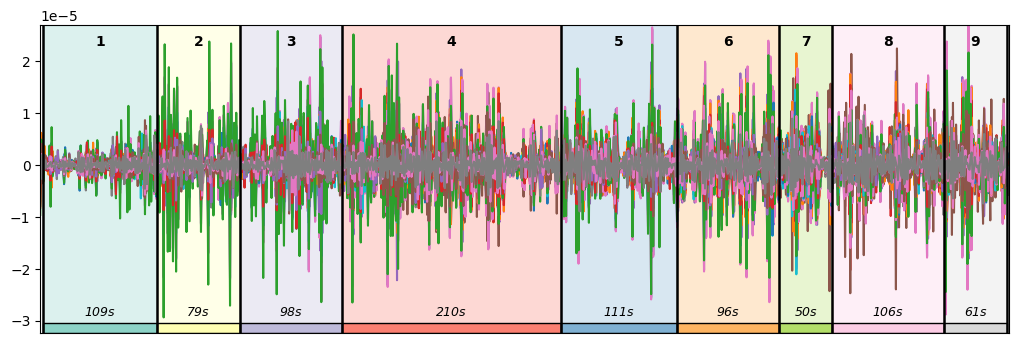

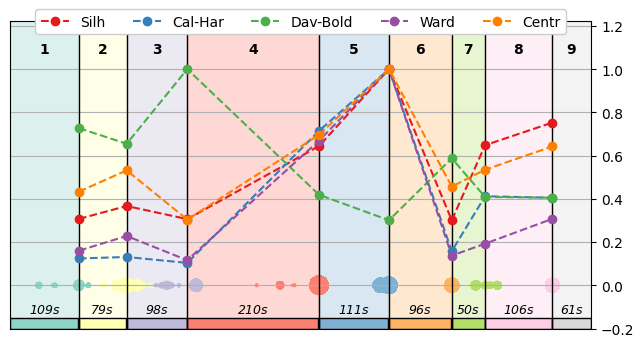

In [15]:
analyze(best_features, 15, "best_topological")

#### Традиционные и топологические вместе + PCA

(1046, 2415)
(1046, 15)
Explained variance 0.58
[0.177, 0.101, 0.064, 0.049, 0.035, 0.022, 0.02, 0.018, 0.016, 0.016, 0.014, 0.014, 0.013, 0.013, 0.012]
Applying to 1046 samples with 15 features each


100%|██████████| 1344/1344 [00:04<00:00, 325.68it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,45,20,Median,40,"[0, 124, 210, 286, 556, 682, 788, 857, 976, 1046]",9,270,69,116.222222,...,31.268506,0.042904,83.872612,2.991398,0.218427,71.498025,1.785822,0.890632,0.784874,0.814117


array([   0,  124,  210,  286,  556,  682,  788,  857,  976, 1046])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 118.7)","(119.5, 198.7)","(199.5, 266.7)","(267.5, 508.3)","(509.1, 620.3)","(621.1, 710.7)","(711.5, 771.5)","(772.3, 877.1)","(877.9, 938.7)"
"Time length, sec",108.8,79.2,67.2,240.8,111.2,89.6,60.0,104.8,60.8
Number of epochs,124,86,76,270,126,106,69,119,70


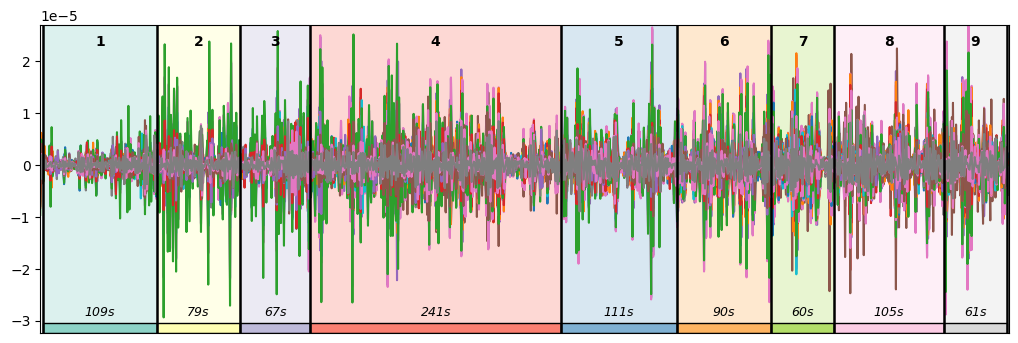

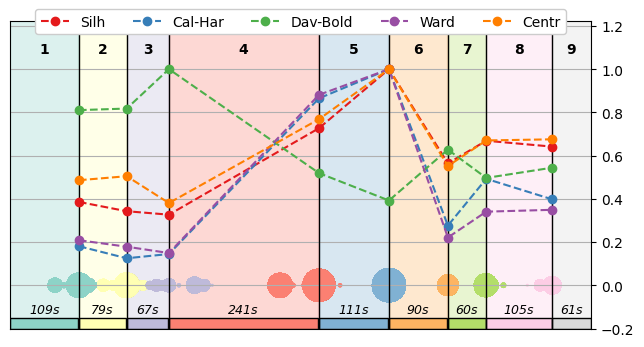

In [16]:
combined_features = pandas.concat([ read_traditional(), best_features ], axis = 1)
analyze(combined_features, 15, "combined")

### Information value

In [37]:
result_edges = numpy.loadtxt(f"{subj}/{exp}/results/best_topological/best_edges.txt").astype(numpy.int32)
print(result_edges)

if os.path.exists(f"{subj}/{exp}/IV/IV.csv"):
    ivs = pandas.read_csv(f"{subj}/{exp}/IV/IV.csv")
else:
    _, labels = SDA.stageprocess.form_stage_bands(result_edges)
    ivs = SDA.analytics.IV.calc_IV_clust(features, labels)

    os.makedirs(f"{subj}/{exp}/IV", exist_ok = True)
    ivs.to_csv(f"{subj}/{exp}/IV/IV.csv", index = False)

ivs["normalized_iv"] = sklearn.preprocessing.MinMaxScaler().fit_transform(ivs[["IV"]])
display(ivs)

[   0  124  210  319  556  682  795  855  976 1046]


,Feature,IV,IVs,normalized_iv
0,channel-0 betti dim-1 max,0.236188,"[0.34407994323404373, 0.03360927304482012, 0.1...",0.092895
1,channel-0 betti dim-1 mean,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
2,channel-0 betti dim-1 std,0.346795,"[0.48177638238239096, 0.13083309903436108, 0.0...",0.136398
3,channel-0 betti dim-1 sum,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
4,channel-0 betti dim-1 percentile-25,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
...,...,...,...,...
19138,overall bd2 dim-3 percentile-75,0.587275,"[0.5709061636651473, 0.5349247378502706, 0.118...",0.230981
19139,overall bd2 dim-3 kurtosis,0.105019,"[0.05596396357518607, 0.1199063761731829, 0.04...",0.041305
19140,overall bd2 dim-3 skew,0.106902,"[0.0632751105737144, 0.008856884199367478, 0.1...",0.042046
19141,overall bd2 dim-3 norm-1,0.353046,"[0.527824146442484, 0.0687343051039016, 0.1564...",0.138857


In [38]:
iv_qsda_scores = scores.join(ivs, lsuffix = "name", rsuffix = "Feature")
iv_qsda_scores = iv_qsda_scores[["name", "unique_values", "score", "normalized_score", "IV", "normalized_iv"]]

iv_qsda_scores["score"] = iv_qsda_scores["score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)
iv_qsda_scores["normalized_score"] = iv_qsda_scores["normalized_score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'score', ascending = False)
iv_qsda_scores["QSDA_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'IV', ascending = False)
iv_qsda_scores["IV_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores["IDX_DIFF"] = iv_qsda_scores["QSDA_IDX"] - iv_qsda_scores["IV_IDX"]

iv_qsda_scores = iv_qsda_scores.sort_index()
display(iv_qsda_scores)

,name,unique_values,score,normalized_score,IV,normalized_iv,QSDA_IDX,IV_IDX,IDX_DIFF
0,channel-0 betti dim-1 max,31,0.000000,0.000000,0.236188,0.092895,19126,5403,13723
1,channel-0 betti dim-1 mean,1,0.000000,0.000000,0.000000,0.000000,15513,19058,-3545
2,channel-0 betti dim-1 std,376,0.622409,0.157015,0.346795,0.136398,8396,4170,4226
3,channel-0 betti dim-1 sum,1,0.000000,0.000000,0.000000,0.000000,12710,17678,-4968
4,channel-0 betti dim-1 percentile-25,1,0.000000,0.000000,0.000000,0.000000,12709,17633,-4924
...,...,...,...,...,...,...,...,...,...
19138,overall bd2 dim-3 percentile-75,858,1.111260,0.256057,0.587275,0.230981,5160,1950,3210
19139,overall bd2 dim-3 kurtosis,462,0.304652,0.092637,0.105019,0.041305,10900,10565,335
19140,overall bd2 dim-3 skew,529,0.581628,0.148753,0.106902,0.042046,8696,10488,-1792
19141,overall bd2 dim-3 norm-1,858,1.910437,0.417972,0.353046,0.138857,1398,4111,-2713


<Axes: >

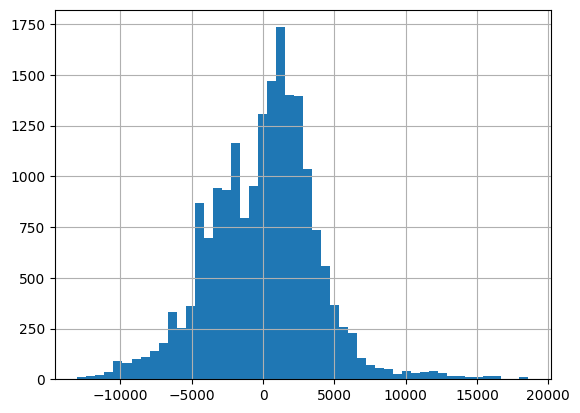

In [39]:
iv_qsda_scores["IDX_DIFF"].hist(bins = 50)

In [40]:
def vec_div(vec):
    mat1 = numpy.repeat(vec.reshape(-1, 1), repeats = len(vec), axis = 1)
    mat2 = numpy.repeat(vec.reshape(1, -1), repeats = len(vec), axis = 0)
    return numpy.sign(mat1 - mat2)

qsda = vec_div(iv_qsda_scores["score"].to_numpy())
iv = vec_div(iv_qsda_scores["IV"].to_numpy())

correct = ((qsda == iv).sum() - iv_qsda_scores.shape[0]) / 2
incorrect = ((qsda != iv).sum() - iv_qsda_scores.shape[0]) / 2

print(correct / 1e6, incorrect / 1e6)

137.110166 46.0979155


In [41]:
def sourceFilter(row):
    if row['Source'].startswith('dissim'):
        return 'dissim'
    return row['Source']

iv_qsda_scores[["Source", "Algorithm", "Dimension", "Stat"]] = iv_qsda_scores['name'].str.split(' ', expand = True)
iv_qsda_scores["Source"] = iv_qsda_scores.apply(sourceFilter, axis = 1)
iv_qsda_scores.to_csv(f"{subj}/{exp}/IV/iv_qsda_scores.csv", index = False)

In [42]:
def SourceRenamer(initial: str) -> str:
    if initial == 'dissim':
        return 'Correlations analysis'
    if initial == 'overall':
        return 'Overall processing'
    ind = initial.find('-') + 1
    comp = int(initial[ind:])
    return f'Comp. {comp} (ch. {epochs.ch_names[comp]})'

def AlgorithmRenamer(row):
    return {
        'amplitude-betti-1':        'Betti amp. with p=1',
        'amplitude-betti-2':        'Betti amp. with p=2',

        'amplitude-bottleneck':     'Bottleneck amp.',
        'amplitude-wasserstein-1':  'Wasserstein amp. with p=1',
        'amplitude-wasserstein-2':  'Wasserstein amp. with p=2',
        
        'amplitude-landscape-1-1':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-1-2':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-2-1':  'Pers. landscape amp. with p=2',
        'amplitude-landscape-2-2':  'Pers. landscape amp. with p=2',
        
        'amplitude-silhouette-1-1': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-1-2': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-2-1': 'Pers. silhouette amp. with p=2',
        'amplitude-silhouette-2-2': 'Pers. silhouette amp. with p=2',

        'bd2':                      'Stat. char. of (b + d) / 2',
        'life':                     'Stat. char. of lifetimes',
        'betti':                    'Stat. char. of Betti curves',
        'landscape':                'Stat. char. of pers. landscape',
        'silhouette-1':             'Stat. char. of lvl 1 pers. silh.',
        'silhouette-2':             'Stat. char. of lvl 2 pers. silh.',
        
        'entropy':                  'Persistence entropy',
        'numberofpoints':           'Number of points',
    }[row]

def DimensionRenamer(row):
    return {
        'all':        'All',
        'dim-1':      'Dimension 1',
        'dim-2':      'Dimension 2',
        'dim-3':      'Dimension 3',
        'dim-4':      'Dimension 4',
        'dim-5':      'Dimension 5',
        'norm-1':     'Amplitude norm with p=1',
        'norm-2':     'Amplitude norm with p=2',
    }[row]

def StatRenamer(row):
    return {
        'kurtosis':      'Kurtosis',
        'skew':          'Skew',
        'max':           'Maximum',
        'mean':          'Mean',
        'median':        'Median',
        'norm-1':        'Norm with p=1',
        'norm-2':        'Norm with p=2',
        'percentile-25': 'Percentile - 25',
        'percentile-75': 'Percentile - 75',
        'std':           'Standard deviation',
        'sum':           'Sum',
    }[row]

def make_stats(data: pandas.DataFrame, group_by: str, sort_by: str):
    stats = data.groupby(by = group_by).mean(numeric_only = True)
    stats = stats.sort_values(by = sort_by).reset_index()
    stats.to_csv(f"{subj}/{exp}/IV/stats_{group_by}_{sort_by}.csv", index = False)
    return stats

def draw(
    data: pandas.DataFrame,
    group_by: str,
    sort_by: str,
    ax,
    renamer: typing.Callable[[str], str],
    title: str
):
    stats = make_stats(data, group_by, sort_by)
    stats[group_by] = stats[group_by].apply(renamer)
    stats.plot.barh(x = group_by, y = sort_by, ax = ax, xlim = (2 * stats[sort_by].min() / 3, None))

    ax.set_title(title)
    ax.get_legend().remove()
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

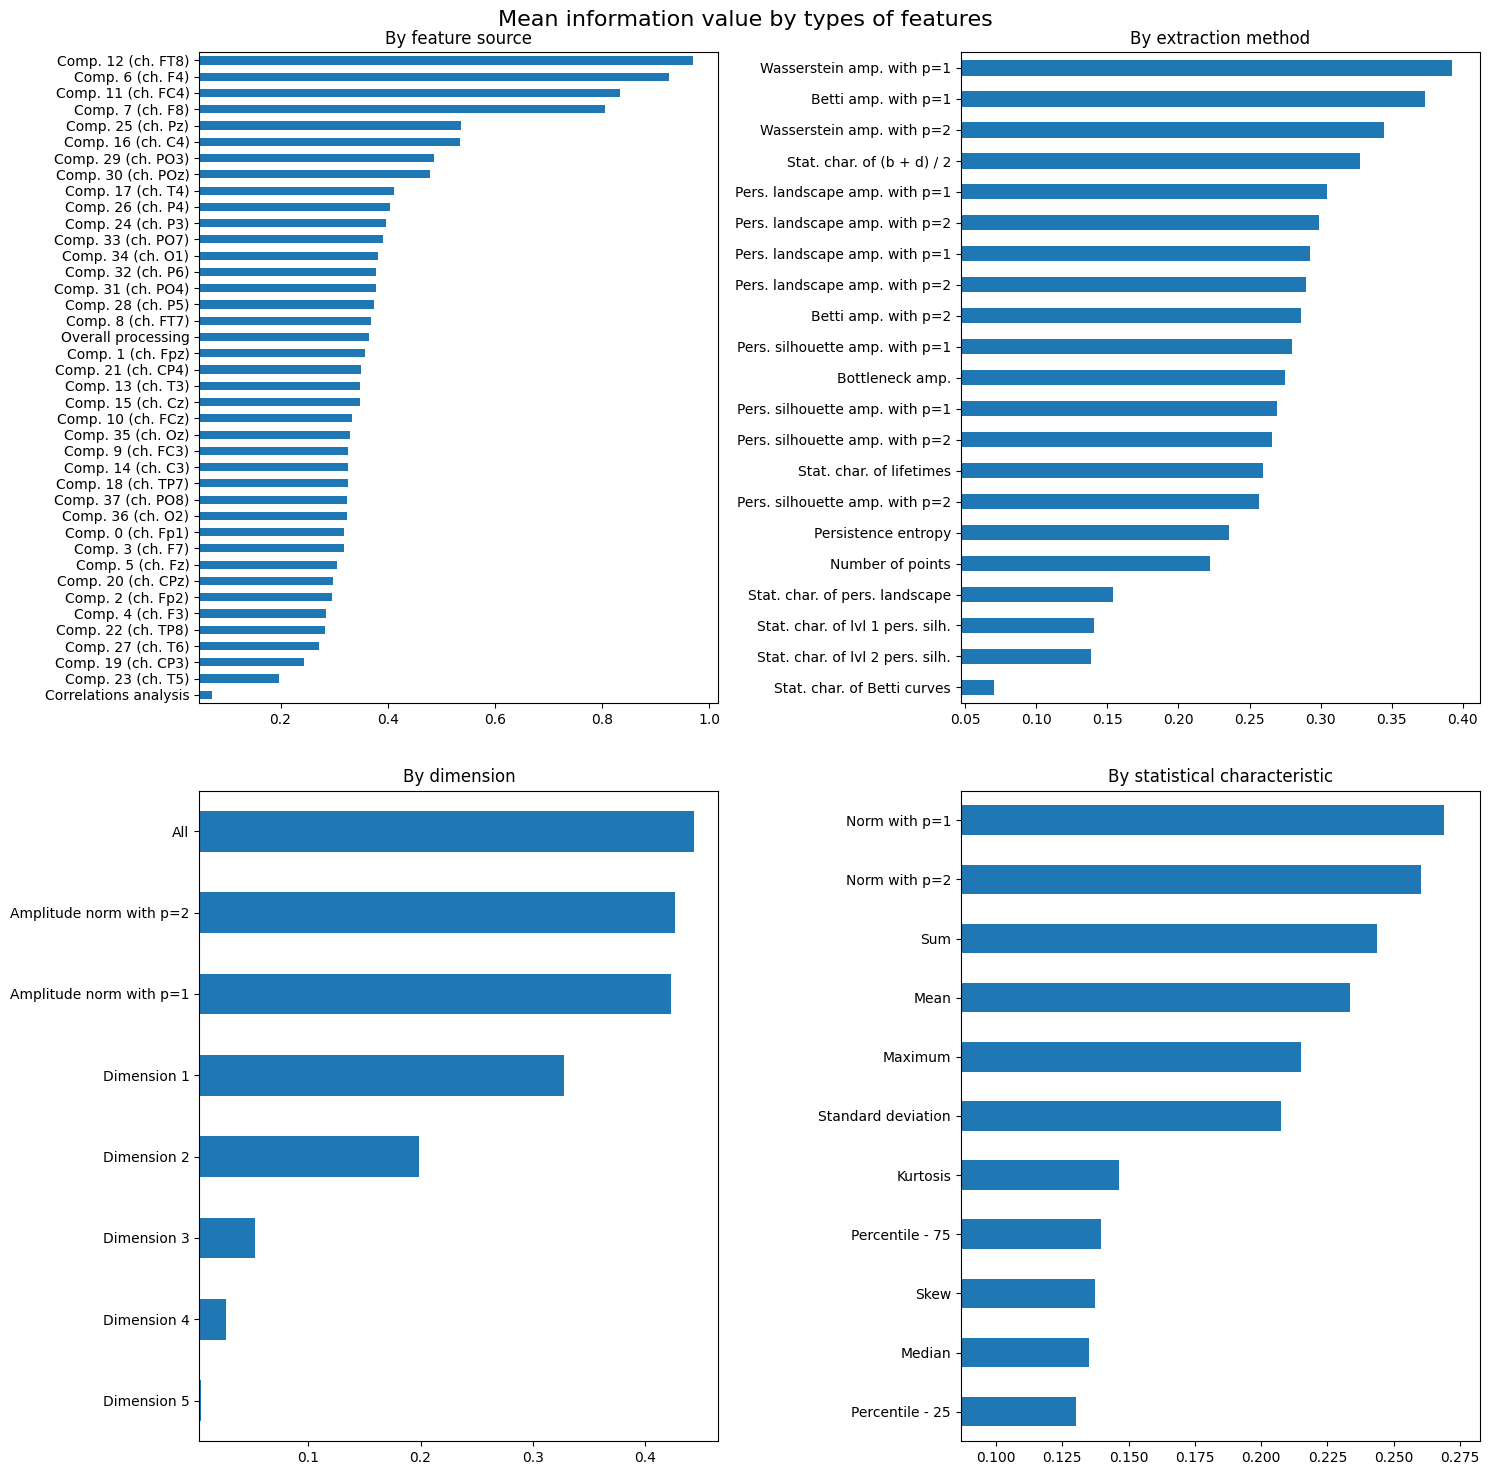

In [43]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
fig.suptitle('Mean information value by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'IV', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'IV', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'IV', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'IV', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.png")

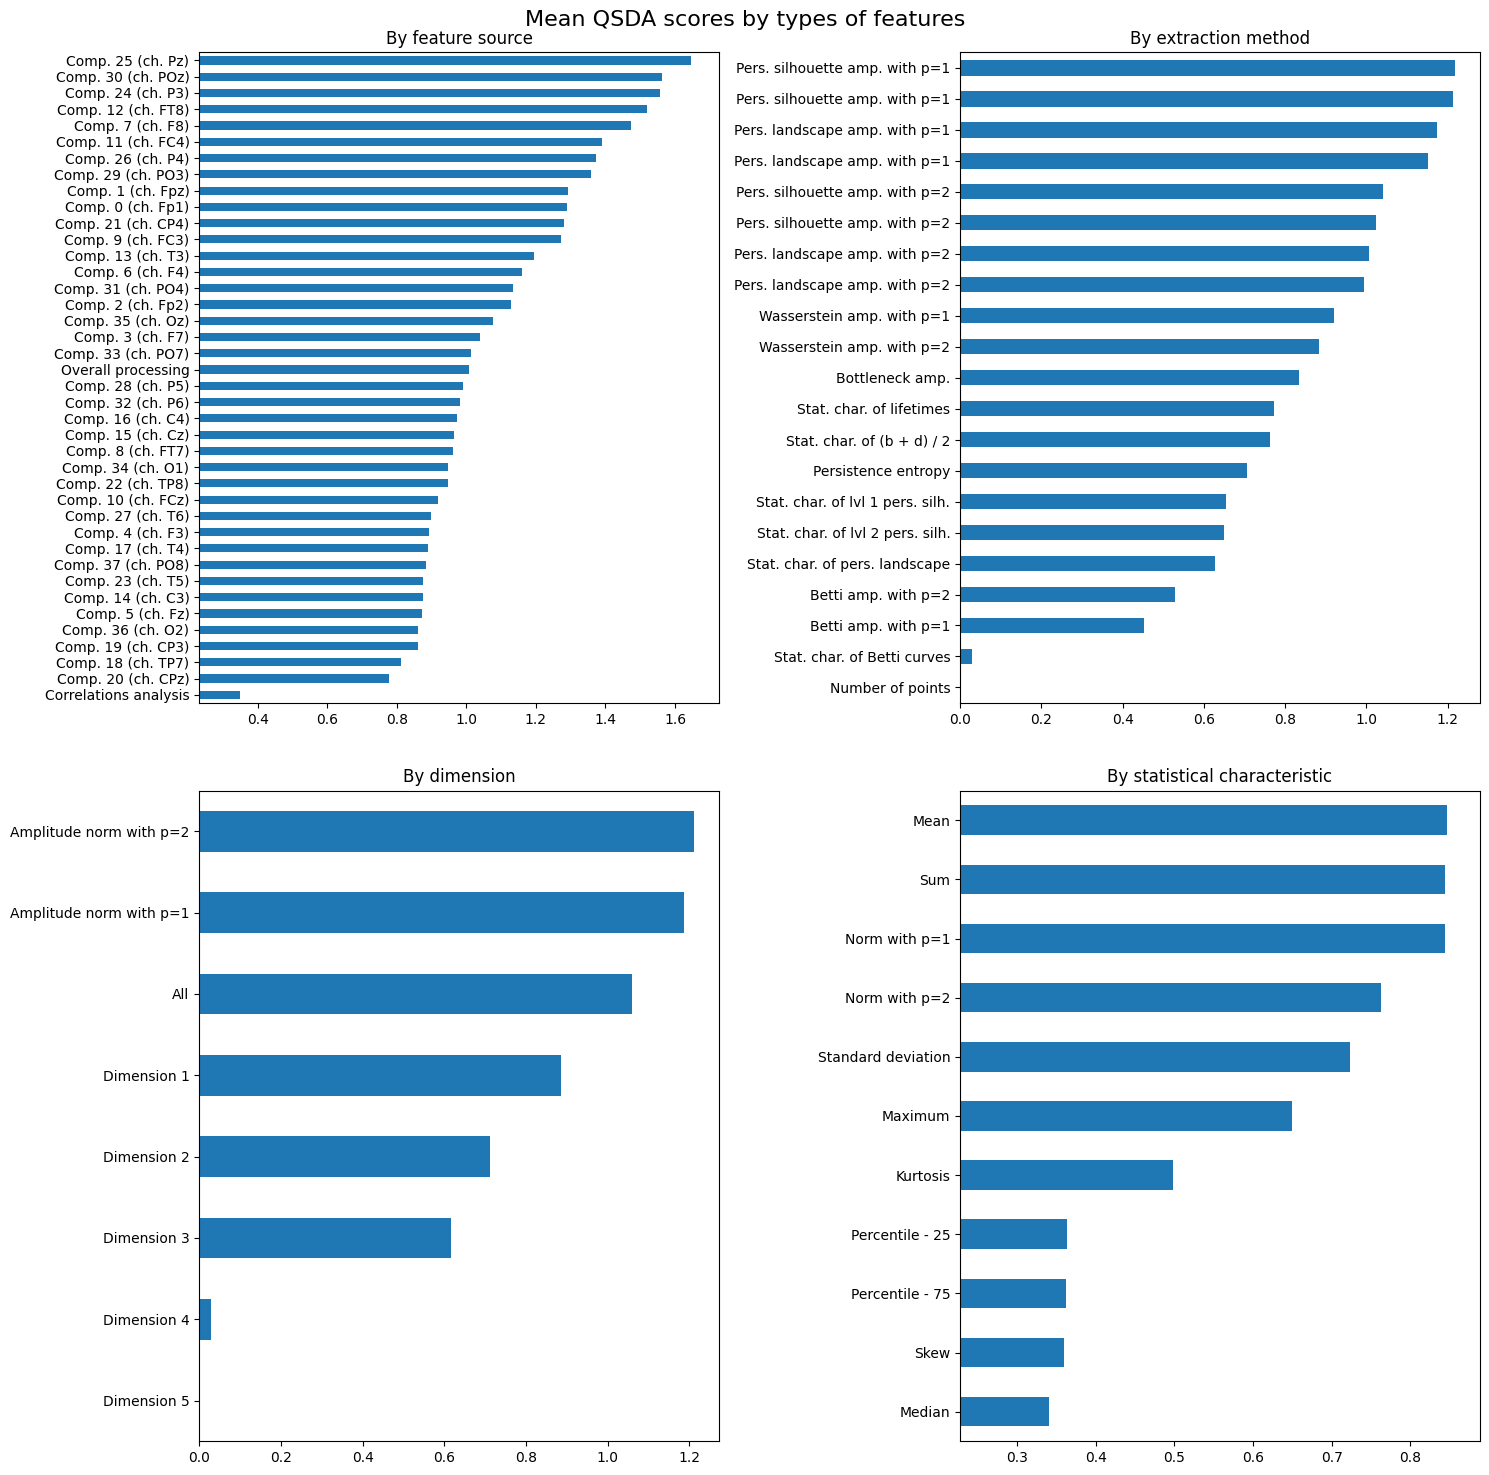

In [44]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
fig.suptitle('Mean QSDA scores by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'score', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'score', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'score', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'score', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.png")

In [56]:
def draw_sources_heatmap(data: pandas.DataFrame, sort_by: str):
    svg = open("report/regions/regions.svg", "r").read()
    svg = svg[svg.find('>') + 1:svg.rfind('<') - 1]
    defs = ""

    stats = make_stats(data, "Source", sort_by)[["Source", sort_by]].sort_values(by = sort_by, ascending = True).reset_index()
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('rg',[[ 1, 0.25, 0 ], [ 1, 0.75, 0 ], [ 0.25, 1, 0 ]], N = 40) 

    for idx, row in stats.iterrows():
        if not row['Source'].startswith('channel-'):
            continue
        id = int(row['Source'][row['Source'].find('-') + 1:])
        color = matplotlib.colors.rgb2hex(cmap(idx))

        id_index = svg.index(f'id="{id}"')
        path_start = svg.rfind("<", 0, id_index)
        path_end = svg.find(">", id_index)

        path = svg[path_start:path_end+1]
        m_idx = path.find("M")
        x = float(path[m_idx + 1:m_idx + 7])
        y = float(path[m_idx + 8:m_idx + 15])

        defs += f"""
            <radialGradient id="gradient{id}">
                <stop offset="0%" stop-color="{color}" stop-opacity="0.66"></stop>
                <stop offset="100%" stop-color="{color}" stop-opacity="0"></stop>
            </radialGradient>
        """
        part = f"""
            <circle cx="{x}" cy="{y - 2}" r="50" fill="url(#gradient{id})"></circle>
            {path.replace(f'id="{id}"', f'fill="{color}" stroke="{color}"')}
        """

        svg = svg[:path_start] + part + svg[path_end+1:]

    svg = f"""
        <svg viewBox="0 0 530 528" fill="none" xmlns="http://www.w3.org/2000/svg">
            <defs> {defs} </defs> {svg}
        </svg>
    """

    file = f"{subj}/{exp}/IV/{sort_by}_regions.svg"
    open(file, "w").write(svg)
    return IPython.display.SVG(file)

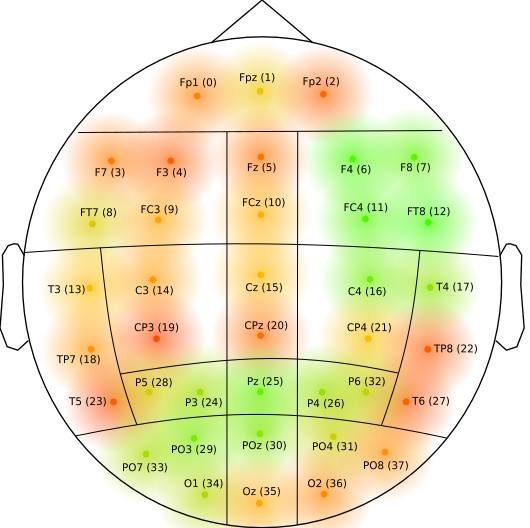

In [57]:
draw_sources_heatmap(iv_qsda_scores, "IV")

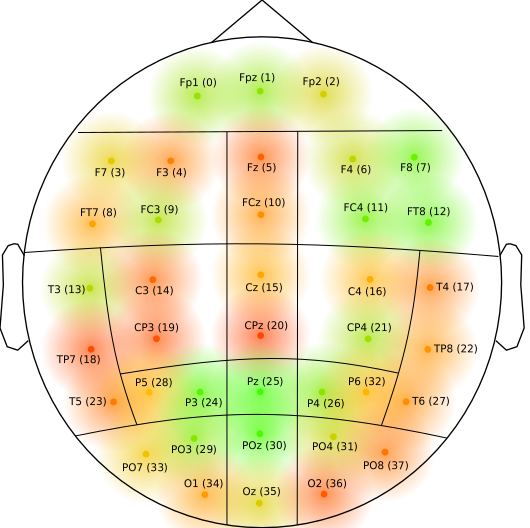

In [58]:
draw_sources_heatmap(iv_qsda_scores, "score")